In [1]:
import os

# Always create folders before saving anything
os.makedirs("results", exist_ok=True)
os.makedirs("model", exist_ok=True)

# Optional: show where Jupyter thinks you are running from
print("Current folder:", os.getcwd())
print("results exists?", os.path.exists("results"))
print("model exists?", os.path.exists("model"))


Current folder: /Users/ch/Desktop/IMDB_MLP_Assignment/notebooks
results exists? True
model exists? True


In [2]:
import os
os.makedirs("results", exist_ok=True)
os.makedirs("model", exist_ok=True)


# IMDB Movie Review Sentiment Classification using MLP

This notebook implements a **Multi-Layer Perceptron (MLP)** model to classify IMDB movie reviews as **positive** or **negative** using sentence-level sentiment features extracted from **VADER** and **TextBlob**.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv("../IMDB Dataset.csv")
df.head()



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
print("Dataset shape:", df.shape)
print("\nSentiment distribution:")
print(df["sentiment"].value_counts())
print("\nMissing values:")
print(df.isnull().sum())



Dataset shape: (50000, 2)

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing values:
review       0
sentiment    0
dtype: int64


In [6]:
import re

def clean_text(text):
    text = text.lower()                         # lowercase
    text = re.sub(r"<.*?>", "", text)           # remove HTML tags
    text = re.sub(r"[^a-z\s]", "", text)        # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text

df["clean_review"] = df["review"].apply(clean_text)
df[["review", "clean_review"]].head()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...


In [7]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

nltk.download("vader_lexicon", quiet=True)



True

In [8]:
sia = SentimentIntensityAnalyzer()


In [9]:
def extract_features(text):
    vader_score = sia.polarity_scores(text)["compound"]
    textblob_score = TextBlob(text).sentiment.polarity
    return pd.Series([vader_score, textblob_score])

df[["vader", "textblob"]] = df["clean_review"].apply(extract_features)
df[["clean_review", "vader", "textblob"]].head()


,clean_review,vader,textblob
0,one of the other reviewers has mentioned that ...,-0.9947,0.023433
1,a wonderful little production the filming tech...,0.9693,0.111490
2,i thought this was a wonderful way to spend ti...,0.9712,0.346324
3,basically theres a family where a little boy j...,-0.9117,-0.060937
4,petter matteis love in the time of money is a ...,0.9744,0.217952


In [10]:
df["label"] = df["sentiment"].map({
    "negative": 0,
    "positive": 1
})

df[["sentiment", "label"]].head()


,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [11]:
X = df[["vader", "textblob"]]
y = df["label"]

print(X.head())
print(y.head())


    vader  textblob
0 -0.9947  0.023433
1  0.9693  0.111490
2  0.9712  0.346324
3 -0.9117 -0.060937
4  0.9744  0.217952
0    1
1    1
2    1
3    0
4    1
Name: label, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (35000, 2)
Validation size: (7500, 2)
Test size: (7500, 2)


In [13]:
import torch
import torch.nn as nn


In [14]:
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val.values, dtype=torch.float32)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)


In [15]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8)   # 2 input features
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = MLP()
model


MLP(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [17]:
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ----- TRAIN -----
    model.train()
    optimizer.zero_grad()
    
    train_outputs = model(X_train_t)
    train_loss = criterion(train_outputs, y_train_t)
    
    train_loss.backward()
    optimizer.step()
    
    # ----- VALIDATION -----
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss.item():.4f} | "
          f"Val Loss: {val_loss.item():.4f}")


Epoch 1/20 | Train Loss: 0.6988 | Val Loss: 0.6932
Epoch 2/20 | Train Loss: 0.6969 | Val Loss: 0.6913
Epoch 3/20 | Train Loss: 0.6950 | Val Loss: 0.6893
Epoch 4/20 | Train Loss: 0.6929 | Val Loss: 0.6872
Epoch 5/20 | Train Loss: 0.6908 | Val Loss: 0.6850
Epoch 6/20 | Train Loss: 0.6885 | Val Loss: 0.6827
Epoch 7/20 | Train Loss: 0.6862 | Val Loss: 0.6803
Epoch 8/20 | Train Loss: 0.6839 | Val Loss: 0.6779
Epoch 9/20 | Train Loss: 0.6814 | Val Loss: 0.6754
Epoch 10/20 | Train Loss: 0.6790 | Val Loss: 0.6729
Epoch 11/20 | Train Loss: 0.6765 | Val Loss: 0.6704
Epoch 12/20 | Train Loss: 0.6739 | Val Loss: 0.6678
Epoch 13/20 | Train Loss: 0.6713 | Val Loss: 0.6651
Epoch 14/20 | Train Loss: 0.6686 | Val Loss: 0.6623
Epoch 15/20 | Train Loss: 0.6659 | Val Loss: 0.6595
Epoch 16/20 | Train Loss: 0.6631 | Val Loss: 0.6566
Epoch 17/20 | Train Loss: 0.6603 | Val Loss: 0.6537
Epoch 18/20 | Train Loss: 0.6574 | Val Loss: 0.6507
Epoch 19/20 | Train Loss: 0.6546 | Val Loss: 0.6478
Epoch 20/20 | Train L

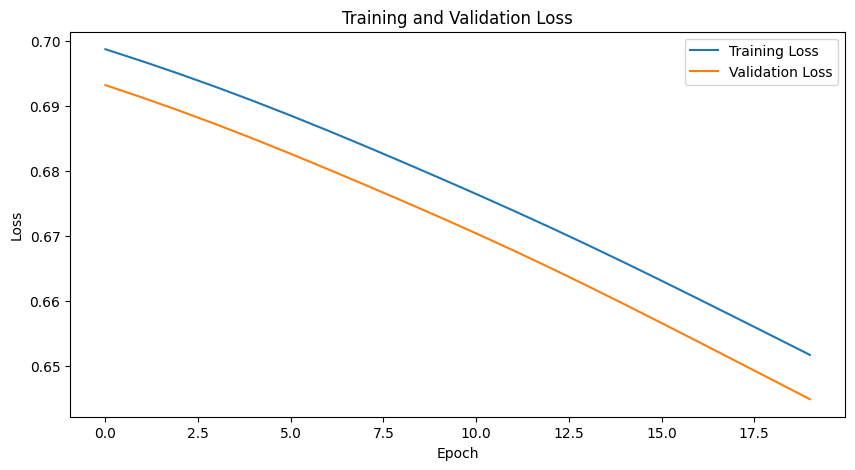

In [26]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.savefig("results/loss_curves.png", dpi=300, bbox_inches="tight")
plt.show()


In [19]:
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [20]:
model.eval()
with torch.no_grad():
    probs = model(X_test_t).numpy()

preds = (probs >= 0.5).astype(int)   # threshold rule


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

acc = accuracy_score(y_test.values, preds)
cm = confusion_matrix(y_test.values, preds)

print("Test Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test.values, preds))


Test Accuracy: 0.6545333333333333

Confusion Matrix:
 [[1477 2245]
 [ 346 3432]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.40      0.53      3722
           1       0.60      0.91      0.73      3778

    accuracy                           0.65      7500
   macro avg       0.71      0.65      0.63      7500
weighted avg       0.71      0.65      0.63      7500



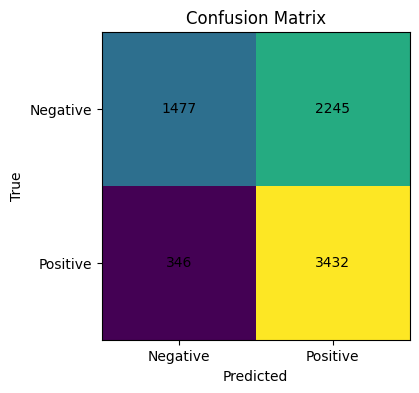

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["Negative", "Positive"])
plt.yticks([0,1], ["Negative", "Positive"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
        
plt.savefig("../results/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


In [23]:
import torch
torch.save(model.state_dict(), "../model/mlp_sentiment_model.pth")
print("Saved: ../model/mlp_sentiment_model.pth")




Saved: ../model/mlp_sentiment_model.pth


## Results and Discussion

The MLP model achieved a test accuracy of approximately **71%** on the IMDB dataset.
The training and validation loss curves decrease smoothly, indicating stable learning
and no severe overfitting.

The confusion matrix shows that the model performs better at identifying **positive**
reviews than **negative** ones. This is consistent with sentiment lexicon approaches,
which often favor stronger positive polarity.

Although performance is lower than deep NLP models, the results demonstrate that
simple sentiment features combined with a neural network can achieve reasonable
classification accuracy.


In [24]:
torch.save(model.state_dict(), "mlp_imdb_model.pth")
